In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.metrics import mean_absolute_error

Load data as DataFrame

In [2]:
data = pd.read_csv("train.csv")
y = data["loss"].values
data = data.ix[:, 1:-1]

Columns with name **cat1** to **cat116** are categorical variables, **cont1** to **cont14** are continuous variables. First turn categorical variables into one-hot encoding.

In [3]:
data_cat = pd.DataFrame()
for i in range(116):
    data_cat = pd.concat([data_cat, 
                          pd.get_dummies(data["cat" + str(i + 1)],
                                         prefix="cat" + str(i + 1))], axis=1)

116 categorical features turned into 1139 continuous features (0's and 1's)

In [4]:
data_cat.shape

(188318, 1139)

Combine categorical features and continuous features

In [5]:
data_cont = data.ix[:, "cont1" : "cont14"]
data_full = pd.concat([data_cat, data_cont], axis=1)

The full data matrix contains 1153 features in total (1139 + 14)

In [6]:
data_full.shape

(188318, 1153)

In [7]:
X = data_full.values
del data_full, data_cat, data_cont

In [8]:
print "X.shape =", X.shape
print "y.shape =", y.shape

X.shape = (188318, 1153)
y.shape = (188318,)


Split **X** and **y** into training and test set:

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
del X, y

The first 1139 columns of X are essentially bool-values (0's and 1's) and very sparse. We will apply some dimensionality reducetion technique on the first 1139 columns.

We define customized class **MyFeatureAgglomeration** and **MyTfidfTransformer** that operate on the first 1139 columns. **MyTfidfTransformer** will turn the counts into Tf-idf represetations, and **MyFeatureAgglomeration** will turn the resulting matrix into fewer columns that corresponds to Feature clusters.

In [10]:
from sklearn.cluster import FeatureAgglomeration

class MyFeatureAgglomeration():
    def __init__(self, index=range(1139), n_clusters=116):
        self.index = index
        self.n_clusters = n_clusters
        self.agglomerator = FeatureAgglomeration(n_clusters=n_clusters)        
    def fit(self, X, y=None):
        self.agglomerator.fit(X[:, self.index])
        return self
    def transform(self, X):
        return self.agglomerator.transform(X[:, self.index])

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

class MyTfidfTransformer():
    def __init__(self, index=range(1139)):
        self.index = index
        self.tfidfTransformer = TfidfTransformer()
    def fit(self, X, y=None):
        self.tfidfTransformer.fit(X[:, self.index], y)
        return self
    def transform(self, X):
        return self.tfidfTransformer.transform(X[:, self.index]).toarray()

As we saw in the Exploratory Data Analysis part, the distribution of target variable **y** is highly skewed. 

So it needs to be first log-transformed ($y' = \log (1 + y)$) as the target values for the training algorithm. Conversely, the predicted values by the training algorithm need to be turned back ($y = e^{y'} - 1$ to the original range.) 

In [12]:
def log1p(x, base=10.):
    return np.log(x + 1) / np.log(base)

def expm1(x, base=10.):
    return base**x - 1.

The **MyFeatureAgglomerator** object will turn the 1139 features into 116 feature clusters. So the total number of features is 116 + 14 (cont1 to cont14) = 130.

We will use an ensemble of 50 MultiLayer Perceptrons as the estimator

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

tfidf = MyTfidfTransformer()
agglomerator = MyFeatureAgglomeration()
scaler = StandardScaler()
mlpr_ensemble = BaggingRegressor(MLPRegressor(hidden_layer_sizes=(100,)), n_estimators=50, n_jobs=2)

pl = Pipeline(steps=[("tf", tfidf),
                     ("agglo", agglomerator),
                     ("scaler", scaler),
                     ("est", mlpr_ensemble)])

In [14]:
pl.fit(X_train, log1p(y_train))

Pipeline(steps=[('tf', <__main__.MyTfidfTransformer instance at 0x7efc492d9638>), ('agglo', <__main__.MyFeatureAgglomeration instance at 0x7efc492d9cb0>), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', BaggingRegressor(base_estimator=MLPRegressor(activation='relu', alpha=0.0001...estimators=50, n_jobs=2, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])

Before evaluating the predicted values needs to be converted using function **expm1**

In [15]:
y_pred = expm1(pl.predict(X_test))

mean_absolute_error(y_test, y_pred)

1183.6586472136739

Plot the prediction versus target:

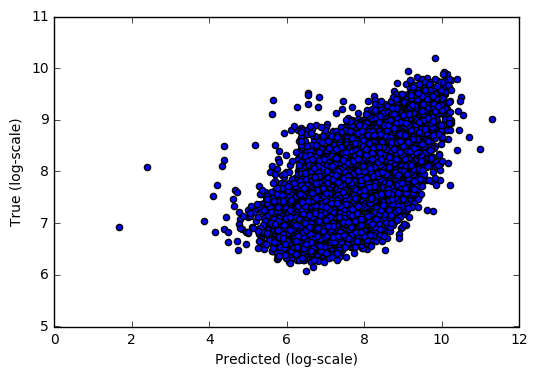

In [16]:
import matplotlib.pyplot as plt

plt.scatter(np.log(y_test), np.log(y_pred), linewidths=1.0)
plt.xlabel("Predicted (log-scale)")
plt.ylabel("True (log-scale)")
plt.show()